First let's load the Jar. This requires `mill q.assembly` to be run beforehand.

In [1]:
interp.load.cp(os.pwd/".."/"out"/"q"/"assembly.dest"/"out.jar")

We will load some boilerplate code for graphing as well.

In [2]:
import $file.makeplot

import $file.$

Now, all the imports...

In [3]:
import riscq._
import riscq.tester._
import spinal.core.sim._
import spinal.core._
import spinal.lib.bus.tilelink.sim._
import spinal.lib.bus.tilelink._
import spinal.lib.bus.amba4.axi.sim.Axi4Master
import riscq.tester.RvAssembler
import riscq.tester.QubicAssembler
import riscq.tester.ByteHelper
import scala.collection.mutable.ArrayBuffer
import spinal.lib._
import riscq.soc.MemoryMapSoc
import riscq.tester.RvAssembler
import riscq.tester.mmsoc.MMSocDriver
import spinal.lib.misc.Elf
import java.io.File
import riscq.soc.MemoryMapSoc
import riscq.soc.MemoryMapPlugins
import net.fornwall.jelf.ElfSectionHeader
import riscq.tester.mmsoc._

import riscq._
import riscq.tester._
import spinal.core.sim._
import spinal.core._
import spinal.lib.bus.tilelink.sim._
import spinal.lib.bus.tilelink._
import spinal.lib.bus.amba4.axi.sim.Axi4Master
import riscq.tester.RvAssembler
import riscq.tester.QubicAssembler
import riscq.tester.ByteHelper
import scala.collection.mutable.ArrayBuffer
import spinal.lib._
import riscq.soc.MemoryMapSoc
import riscq.tester.RvAssembler
import riscq.tester.mmsoc.MMSocDriver
import spinal.lib.misc.Elf
import java.io.File
import riscq.soc.MemoryMapSoc
import riscq.soc.MemoryMapPlugins
import net.fornwall.jelf.ElfSectionHeader
import riscq.tester.mmsoc._

Copying over the body of `TestMMSocPulse` from `MMSocTestBench.scala` and pushing the DAC outputs into an `ArrayBuffer`

In [4]:
val dac_output = ArrayBuffer[Double]()
val carrier_output = ArrayBuffer[Double]()
val simConfig = SimConfig.addSimulatorFlag("-Wno-MULTIDRIVEN")
  simConfig
    .compile {
      val dut = MemoryMapSoc(
        qubitNum = 4,
        withVivado = false,
        withCocotb = false,
        withWhitebox = true,
        withTest = true
      ) 
      dut.pgs.map { _.io.simPublic() }
      dut.cgs.map { _.io.simPublic() }
      dut
    }
    .doSim { dut =>
      val driver = new Driver(dut)
      import driver._

      init()


      val batchSize = 16
      val dataWidth = 16
      for (i <- 0 until 100) {
        val dt = if (i == 0) BigInt(10) else BigInt(1000)
        val batch = List.fill(batchSize)(dt)
        val batchData = riscq.pulse.PGTestPulse.concat(batch, dataWidth)
        val dataStr = batch.map { x => ByteHelper.intToBinStr(x, dataWidth) }.reduce { _ ++ _ }
        tlDriver.putFullData(0, dut.pmAxiOffset + (1 << 21) + i * batchSize * dataWidth / 8, ByteHelper.fromBinStr(dataStr).reverse)
        // axi4Driver.write(dut.pmAxiOffset + i * batchSize * dataWidth / 8, ByteHelper.fromBinStr(dataStr).reverse.toList)
      }
      cd100m.waitRisingEdge()


      val elfFile = new File("../compiler-scripts/pg_test.elf")
      val elf = new Elf(elfFile, addressWidth = 32)
      elf.load(dut.mem.mem, -0x80000000)

      val startTime = 50

      dut.riscq_rst #= true
      tick(10)
      dut.riscq_rst #= false

      val monitor = new Monitor(dut.dBus.bus, cd)
      val pcReset = 0x80000000l
      monitor.add(new MonitorSubscriber {
        override def onA(a: TransactionA) = {println(s"${simTime()}"); println(a)}
        override def onD(d: TransactionD) = {println(s"!!!!!!!${simTime()}");println(d)}
      })

      tick(30)
      for(t <- 100 until 500 by 100) {
        driver.waitUntil(t - 1)
        for(i <- 0 until 10) {
          logTime()
          logDac(1)
          logCarrier(1)
          tick()
        }
      }
        
      // waitUntil(99)
      for (i <- 0 until 10) {
        // println(s"${dut.mem.mem.getBigInt(0).toString(16)}")
        // println(s"${dut.mem.mem.getBigInt(0x1d).toString(16)}")
        // println(s"${dut.mmFiber.logic.cgParams(0).cgIo.freq.toDouble}")
        // println(s"bypass: ${wb.hazard.bypass_1.map{case (id, data) => (id, data.toBoolean)}}")
        logTime()
        // logBranch()
        // logHazard()
        // logPcs()
        // logSrc()
        // logExInsts()
        logDac(2)
        println("")
        val dac = dut.pgs(2).io.data
        val pulse = dac.payload.map { _.r.toDouble * (1 << 14) }.toList
        dac_output ++= pulse
        val carrier = dut.cgs(2).io.carrier
        val data = carrier.payload.map { _.r.toDouble * (1 << 14) }.toList
        carrier_output ++= data
        tick()
      }
    }


[Runtime] SpinalHDL dev    git head : bbe3c9911a233a5aa9672c70d237336385ab7dcc
[Runtime] JVM max memory : 3910.0MiB
[Runtime] Current date : 2025.04.05 12:25:53
[Progress] at 0.000 : Elaborate components
debug jumps: ArrayBuffer(toplevel/riscqArea_riscq/null)
########################1
debug hazard ctrlrange: Range 0 to 0
debug hazard ds: 0
!!!!!!!!!!!!!###########Range 0 until 2
!!!!!!!!!!!!!###########Range 0 until 2
[Progress] at 4.247 : Checks and transforms
[Progress] at 8.126 : Generate Verilog to ./simWorkspace/tmp/job_1
[Warning] toplevel/riscqArea_riscq/integer_RegFilePlugin_logic_regfile_fpga/asMem_ram : Mem[32*32 bits].readAsync can only be write first into Verilog
[Warning] toplevel/riscqArea_riscq/integer_RegFilePlugin_logic_regfile_fpga/asMem_ram : Mem[32*32 bits].readAsync can only be write first into Verilog
[Warning] toplevel/cd100mLogic_pulseMemWa_logic_bridge/upsize_d_ctx/contexts : Mem[16*3 bits].readAsync can only be write first into Verilog
[Warning] toplevel/riscq

List(5875.0, -704.0, 17149.0, -14421.0, -11477.0, 6109.0, -27726.0, -16883.0, -521.0, 11481.0, -18373.0, 14704.0, -31680.0, -4862.0, -7275.0, 11804.0)
time: 200
pulse ev: v: false, amp: 24645, start: 649
pulse: List(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
carrier ev: v: false, freq: -0.0859375, phase: 0.2568359375
List(-5295.0, 111.0, -14769.0, 16234.0, 12854.0, -4969.0, 27917.0, 16396.0, -1440.0, -9906.0, 19085.0, -15335.0, 32572.0, 5767.0, 8730.0, -12128.0)
time: 201
pulse ev: v: false, amp: 24645, start: 649
pulse: List(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
carrier ev: v: false, freq: -0.0859375, phase: 0.2568359375
List(4695.0, 478.0, 12341.0, -17978.0, -14176.0, 3813.0, -28001.0, -15849.0, 3386.0, 8297.0, -19720.0, 15901.0, 32200.0, -6648.0, -10146.0, 12402.0)
time: 202
pulse ev: v: false, amp: 24645, start: 649
pulse: List(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

List(-43.0, -4488.0, 5758.0, 27974.0, 21696.0, 4570.0, 25440.0, 10303.0, -16415.0, 3703.0, 21887.0, -18029.0, -30672.0, 11965.0, 18759.0, -12908.0)
!!!!!!!185140
ACCESS_ACK_DATA param=0 source=0 addr=0x4008 bytes=4
- 00 00 00 00

!!!!!!!185150
ACCESS_ACK_DATA param=0 source=1 addr=0x4008 bytes=4
- 00 00 00 00

185250
PUT_FULL_DATA param=0 source=0 addr=0x20200 bytes=4
- cc 0c 00 00

185260
PUT_FULL_DATA param=0 source=1 addr=0x20204 bytes=4
- 00 00 00 00

!!!!!!!185300
ACCESS_ACK param=0 source=0 addr=0x20200 bytes=4

185310
PUT_FULL_DATA param=0 source=0 addr=0x10200 bytes=4
- 00 00 00 00

!!!!!!!185310
ACCESS_ACK param=0 source=1 addr=0x20204 bytes=4

185320
PUT_FULL_DATA param=0 source=1 addr=0x10204 bytes=4
- 00 70 00 00

!!!!!!!185360
ACCESS_ACK param=0 source=0 addr=0x10200 bytes=4

185370
PUT_FULL_DATA param=0 source=0 addr=0x10208 bytes=4
- 04 00 00 00

!!!!!!!185370
ACCESS_ACK param=0 source=1 addr=0x10204 bytes=4

185380
PUT_FULL_DATA param=0 source=1 addr=0x1020c bytes=4
- 0

dac_output: ArrayBuffer[Double] = ArrayBuffer(
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
...
carrier_output: ArrayBuffer[Double] = ArrayBuffer(
  11654.0,
  7527.0,
  2664.0,
  -2460.0,
  -7344.0,
  -11509.0,
  -14548.0,
  -16164.0,
  -16198.0,
  -14648.0,
  -11664.0,
  -7540.0,
  -2677.0,
  2447.0,
  7332.0,
  11498.0,
  14541.0,
  16161.0,
  16200.0,
  14653.0,
  11673.0,
  7550.0,
  2689.0,
  -2435.0,
  -7321.0,
  -11492.0,
  -14537.0,
  -16161.0,
  -16203.0,
  -14661.0,
  -11684.0,
  -7564.0,
  -2702.0,
  2423.0,
  7310.0,
  11482.0,
  14531.0,
  16158.0,
...
simConfig: SpinalSimConfig = SpinalSimConfig(
  "./simWorkspace",
  null,
  0,
  SpinalConfig(
    null,
    Set(),
    Set(),
    false,
    ClockDomainConfig(RISING, ASYNC, HIGH, HIGH, HIGH),
    false,
 

Plotting...

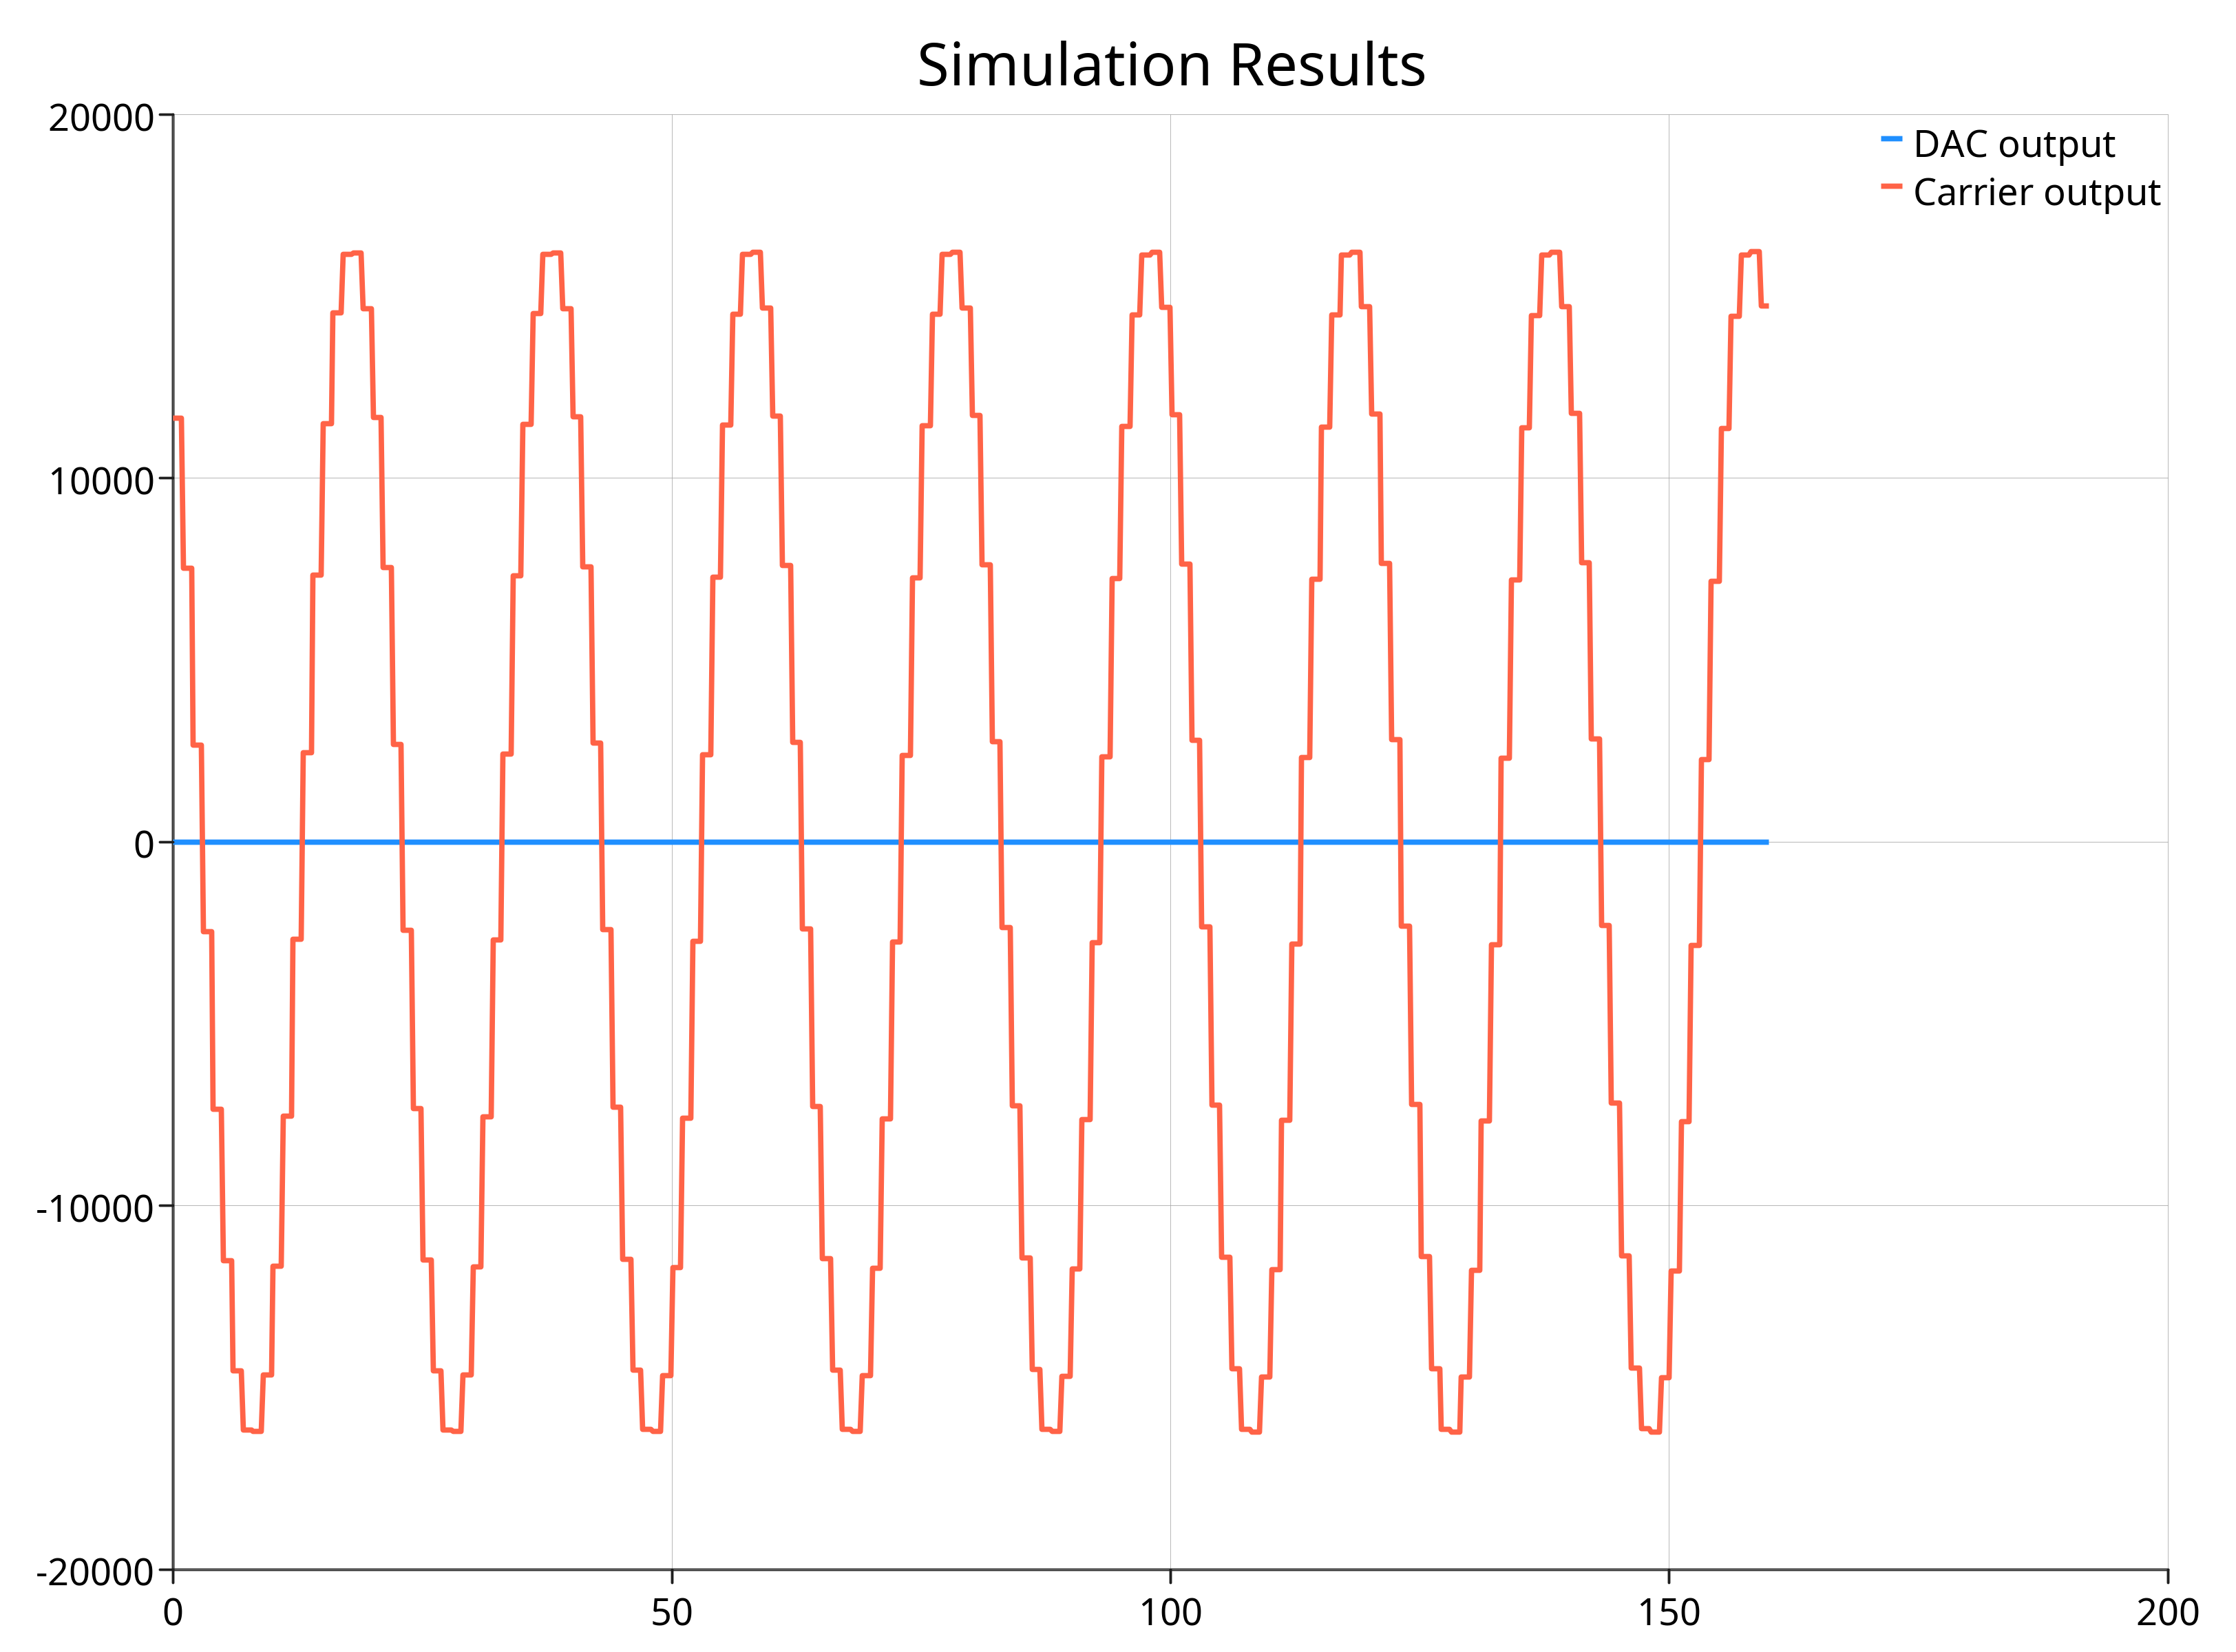

pngBytes: Array[Byte] = Array(
  -119,
  80,
  78,
  71,
  13,
  10,
  26,
  10,
  0,
  0,
  0,
  13,
  73,
  72,
  68,
  82,
  0,
  0,
  12,
  -80,
  0,
  0,
  9,
  96,
  8,
  6,
  0,
  0,
  0,
  34,
  11,
  47,
  101,
  0,
  0,
  -128,
  0,
  73,
...

In [5]:
val pngBytes = makeplot.make_plot(List(makeplot.LabeledData("DAC output", dac_output), makeplot.LabeledData("Carrier output", carrier_output)))
Image(pngBytes)